# PLDS Filtering

In [1]:
using Distributions, Plots, ForwardDiff, Images

# Model Specification

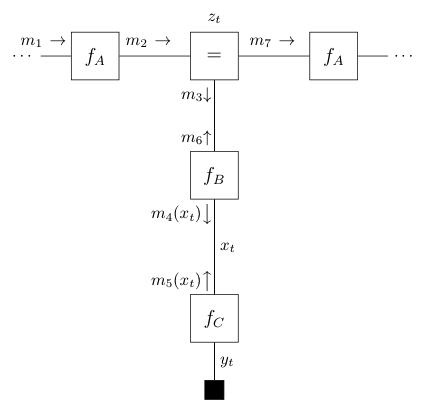

In [2]:
img = load("PLDS.png")

$$
\begin{align}
    f_{A}(z_1) &= \mathcal{N}(z_1;\mu^{z_{1}},\nu^{z_{1}}) \nonumber \\
    f_{A}(z_{t-1},z_t) &= \mathcal{N}(z_t;\alpha z_{t-1},\nu^{z}) \nonumber \\
    f_{B}(x_{t},z_t) &= \mathcal{N}(x_t;\beta z_{t},\nu^{x}) \nonumber \\
    f_{C}(y_{t},x_t) &= \mathcal{PO}(y_t;\exp{(x_t)}) \label{eq:PLDS_generative}
\end{align}
$$

where $\mu^{z_{1}}$, $\nu^{z_{1}}$, $\alpha$, $\beta$, $\nu^{z}$, $\nu^{x}$ are called prior mean for first latent state, prior variance for first latent state, transition coefficient, preobservation coefficient, transition noise, and preobservation noise respectively.

## Messages

$ m_1 = \mathcal{N}(\mu_1,\nu_1) $

$ m_2 = \mathcal{N}(\mu_2,\nu_2) = \mathcal{N}(\alpha \mu_1,\alpha^2 \nu_1 + \nu^z) $

$ m_3 = \mathcal{N}(\mu_3,\nu_3) = m_2 $

$ m_4 = \mathcal{N}(\mu_4,\nu_4) = \mathcal{N}(\beta \mu_3, \beta^2 \nu_3 + \nu^x) $

$ m_5 = \mathcal{PO}(\hat{y}_t; \exp(x_t)) $

$ m_6 \propto \exp(\mathbb{E}_{q(x_{t})}[\log f_B(x_t,z_t)]) \propto \mathcal{N}(a_t/\beta,\nu^x/\beta^2) $

$ m_7 = m_2 \cdot m_6 = \mathcal{N}\left( \frac{\mu_2 \cdot \nu_6 + \mu_6 \cdot \nu_2}{\nu_2 + \nu_6}, \frac{\nu_2 \cdot \nu_6}{\nu_2 + \nu_6} \right) $

# Synthetic Data

In [3]:
#synthetic dataset
T = 80

A = 0.95
B = 0.25

v_z = 0.2
v_x = 0.1

z = [12.0]
x = [rand(Normal(B*z[1],sqrt(v_x)))]
y = [rand(Poisson(exp(x[1])))]

for t=1:(T-1)
    append!(z, rand(Normal(A*z[end],sqrt(v_z))))
    append!(x, rand(Normal(B*z[end],sqrt(v_x))))
    append!(y, rand(Poisson(exp(x[end]))))
end

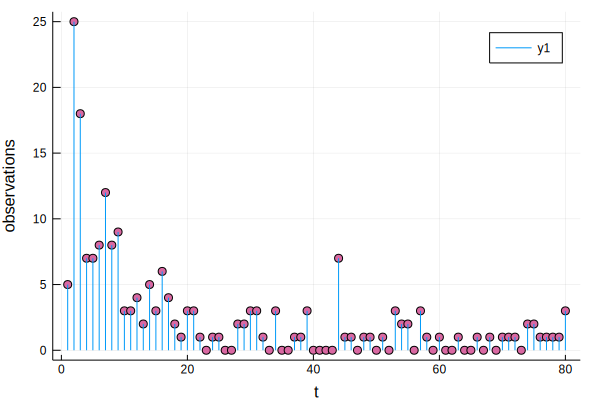

In [4]:
#stem(collect(1:T), y, linefmt="k-", basefmt="k")
#setp(color='r', linewidth=2)
plot(collect(1:T), y, seriestype=:stem, markershape=:circle)
xlabel!("t")
ylabel!("observations")

## Inference

In [5]:
#likelihood function
function like_var(x,y)
    return pdf(Poisson(exp(x)),y)
end

like_var (generic function with 1 method)

In [6]:
#message computation at node f_A
function forward_var(A, n_v, m_mu, m_v)
    mu = A*m_mu
    v = (A^2)*m_v + n_v
    return mu, v
end

forward_var (generic function with 1 method)

In [7]:
#message computation at equality node
function eq_var(m1_mu, m1_v, m2_mu, m2_v)
    v = (m1_v*m2_v)/(m1_v+m2_v)
    mu = v*(m1_mu/m1_v + m2_mu/m2_v)
    return mu, v
end

eq_var (generic function with 1 method)

In [8]:
#differentiable reparameterization function for Gaussian
function g(epsilon, a, b)
    return a + b*epsilon
end

g (generic function with 1 method)

In [9]:
#approximating exact marginal posterior with gaussian q and auto-vi
function gaussian_avi(log_fA, log_fB, mu_prior, v_prior, eta_a, eta_b, num_epoch, num_epoch2)
    sum_a = 0
    sum_b = 0
    a_t = mu_prior
    b_t = sqrt(v_prior)
    for epoch2=1:num_epoch2
        for epoch=1:num_epoch
            message_6 = rand(Normal(0,1),1)[1]
            epsilon = message_6
            message_7 = a_t
            message_8 = b_t
            message_9 = g(message_6, message_7, message_8)
            x_sample = message_9
            message_10 = x_sample
            message_11 = x_sample
            message_1 = ForwardDiff.derivative(log_fA, x_sample)
            message_2 = ForwardDiff.derivative(log_fB, x_sample)
            message_3 = message_1 + message_2
            g_a(a) = g(epsilon, a, b_t)
            message_4 = message_3 * ForwardDiff.derivative(g_a, a_t)
            g_b(b) = g(epsilon, a_t, b)
            message_5 = message_3 * ForwardDiff.derivative(g_b, b_t) + 1.0/b_t
            sum_a += message_4
            sum_b += message_5
        end
        a_t = a_t + eta_a*sum_a/num_epoch
        b_t = b_t + eta_b*sum_b/num_epoch
    end
    return a_t, b_t^2
end

gaussian_avi (generic function with 1 method)

In [10]:
#julia's look-up table for factorials does not contain values larger than 20
function find_factorial(x)
    mult = 1.0
    if x==0
        return mult
    else
        for i=1:x
            mult = mult*i
        end
        return mult
    end
end

find_factorial (generic function with 1 method)

In [11]:
p_mu = 10 #prior mean for z_1
p_v = 10 #prior variance z_1
mu_fA_z_list = ones(T)*p_mu #keeps mean of messages from f_A to z
v_fA_z_list = ones(T)*p_v #keeps variance of messages from f_A to z
mu_eq_zpp_list = ones(T)*p_mu #keeps mean of messages from eq to z
v_eq_zpp_list = ones(T)*p_v #keeps variance of messages from eq to z
mu_xt_list = ones(T) #keeps posterior mean values for x
v_xt_list = ones(T) #keeps posterior variance values for x
v_x_ant = 0.5 #preobservation noise used for inference
v_z_ant = 0.4 #transition noise used for inference
#forward pass
for t=1:T
    if t != 1
        mu_fA_z, v_fA_z = forward_var(A, v_z_ant, mu_eq_zpp_list[t-1], v_eq_zpp_list[t-1]) #mean and var of incoming messages to z_t
        mu_fA_z_list[t], v_fA_z_list[t] = mu_fA_z, v_fA_z #update the list of incoming mean messages to z
    end
    mu_fB_x, v_fB_x = forward_var(B, v_x_ant, mu_fA_z_list[t], v_fA_z_list[t]) #mean and var of incoming messages to x_t
    fB(s) = pdf(Normal(mu_fB_x, v_fB_x),s) #formulate f_B as prior node for x_t
    log_fB(s) = log(fB(s))
    fC(s) = (exp(s)^y[t])*exp(-exp(s))/find_factorial(y[t]) #formulate f_B as likelihood node for y_t. sth wrong with poisson in julia
    log_fC(s) = y[t]*log(exp(s)) - exp(s) - log(find_factorial(y[t]))
    mu_xt, v_xt = gaussian_avi(log_fB, log_fC, mu_fB_x, v_fB_x, 0.001, 0.000001, 50, 500) #posterior mean and variance estimated with reparameterization gradient vi
    mu_xt_list[t], v_xt_list[t] = mu_xt, v_xt #update list for x
    mu_eq_zpp_list[t], v_eq_zpp_list[t] = eq_var(mu_fA_z_list[t], v_fA_z_list[t], mu_xt_list[t]/B, v_x_ant/(B^2)) #VMP from f_B to z_t
end

In [13]:
anim = @animate for i = 1:T
    s = plot()
    plot!(collect(1:i), z[1:i], color = :magenta, linewidth = 3, label="true z", xlims=(0,T), ylims=(-5,15))
    plot!([mu_eq_zpp_list[1:i],mu_eq_zpp_list[1:i]],color=:black, linestyle=:dash,linewidth = 2,label="inferred z",fillrange = [mu_eq_zpp_list[1:i]-sqrt.(v_eq_zpp_list[1:i]),mu_eq_zpp_list[1:i]+sqrt.(v_eq_zpp_list[1:i])],
        fillalpha = 0.2,
        fillcolor = :red)
    xlabel!("t")
    ylabel!("hidden states")
end
gif(anim, "plds.gif", fps = 5)

┌ Info: Saved animation to 
│   fn = /Users/sakbayrak/Codes/semih/RGMP/plds.gif
└ @ Plots /Users/sakbayrak/.julia/packages/Plots/UQI78/src/animation.jl:90


Plots.AnimatedGif("/Users/sakbayrak/Codes/semih/RGMP/plds.gif")